# Determining Student Knowledge Status

### Introduction

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five standardized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

### Preliminary Exploratory Data Analysis

In [8]:
## Run this cell before continuing
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)


The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

The dataset is already split into training and testing data, so we do not have to perform an initial split to separate the data. Now, let's read in our training and testing data:

In [9]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "data/Data_User_Modeling_Dataset.xls")
knowledge_training <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 2) %>%
    select(STG:UNS)
knowledge_testing <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 3) %>%
    select(STG:UNS)

head(knowledge_training, n = 5)
head(knowledge_testing, n = 5)

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


Note that the first five variables appear to be normalized to be in the range [0, 1]. This will actually make things easier for us when training our classification model!

Additionaly, note that out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [10]:
knowledge_testing <- knowledge_testing %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)
knowledge_training <- knowledge_training %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)
head(knowledge_testing, n = 5)
head(knowledge_training, n = 5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


That's better. Let's continue tidying up the data!

A few changes will make this data easier to work with:
- Firstly, transform all knowledge level (SKL) labels to lower case
- Then transform the knowledge level (SKL) column to be a factor column instead of the current character column.

In [11]:
knowledge_testing <- knowledge_testing %>%
    mutate(SKL = as_factor(tolower(SKL)))
knowledge_training <- knowledge_training %>%
    mutate(SKL = as_factor(tolower(SKL)))
head(knowledge_testing, n=5)
head(knowledge_training, n=5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very low
0.05,0.05,0.55,0.60,0.14,low
0.08,0.18,0.63,0.60,0.85,high
0.20,0.20,0.68,0.67,0.85,high
0.22,0.22,0.90,0.30,0.90,high


STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
0.10,0.10,0.15,0.65,0.30,middle
0.08,0.08,0.08,0.98,0.24,low


There, that's more like it.

Now, the wide format in which this data is currently represented is not exactly tidy. For one thing, how does one know what the numbers represent? Without contextual knowledge, this format makes it impossible to know. To solve this problem, we reshape the data set to a tidy data format by adding two columns:
1. a 'Preparation Degree' column, which averages the study times and repetition numbers for both goal and related object materials, named `prep`
2. a 'Examination Result' column, which averages the normalized exam results for both goal and related object materials, named `exam`

In [12]:
# code here to add the columns
knowledge_training = mutate(knowledge_training, 
                            prep = (STG + RNG + STR)/3,
                            exam = (EPR + EPG)/2)
knowledge_testing = mutate(knowledge_testing, 
                           prep = (STG + RNG + STR)/3,
                           exam = (EPR + EPG)/2)
head(knowledge_training, n=5)
head(knowledge_testing, n=5)

STG,RNG,STR,EPR,EPG,SKL,prep,exam
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,very_low,0.00000000,0.000
0.08,0.08,0.10,0.24,0.90,high,0.08666667,0.570
0.06,0.06,0.05,0.25,0.33,low,0.05666667,0.290
0.10,0.10,0.15,0.65,0.30,middle,0.11666667,0.475
0.08,0.08,0.08,0.98,0.24,low,0.08000000,0.610


STG,RNG,STR,EPR,EPG,SKL,prep,exam
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.10,0.50,0.26,0.05,very low,0.2000000,0.155
0.05,0.05,0.55,0.60,0.14,low,0.2166667,0.370
0.08,0.18,0.63,0.60,0.85,high,0.2966667,0.725
0.20,0.20,0.68,0.67,0.85,high,0.3600000,0.760
0.22,0.22,0.90,0.30,0.90,high,0.4466667,0.600


< Description here of the knn algorithm >

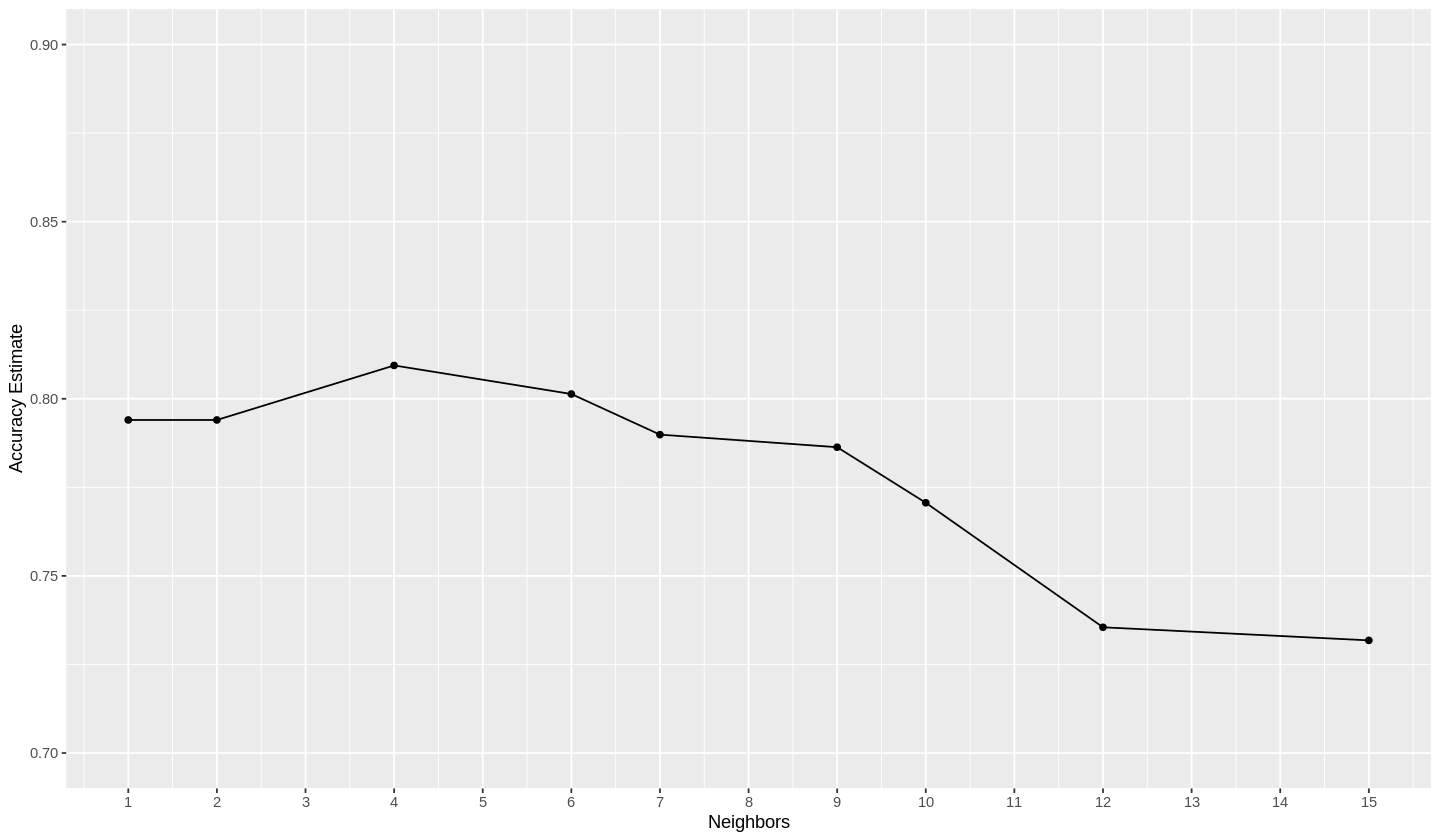

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)
set.seed(18)

# Create the knn recipe 
knn_recipe <- recipe(SKL ~ STG + RNG + STR + EPR + EPG, data = knowledge_training)

# Create the knn spec to find the best k- value 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create the v-fold 
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = SKL)

# Create the workflow and collect statistics
knn_results <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = knowledge_vfold, grid = 10) %>%
    collect_metrics()

# Calculate and plot accuracy estimates
accuracies <- knn_results %>%
    filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +
    scale_y_continuous(limits = c(0.7, 0.9))
accuracy_versus_k

Based on the plot above, we see that k = 4 would be a good choice for our k since this gives us the highest accuracy estimate, and choosing values close to k = 4 would not decrease our accuracy by so much.

Now, we use our best choice of k to create our final fit model. 

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_fit <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = knowledge_training)


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~4, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1860465
Best kernel: rectangular
Best k: 4